## Group Name : Unfiltered Commentary

- Raees Moosa : 2322203
- Oriinga Maudu : 2433303
- Tumi Jourdan : 2180153

In [77]:
import numpy as np
import imageio.v2 as imageio
from glob import glob
from skimage import img_as_float32
from natsort import natsorted
import matplotlib.pyplot as plt
import cv2
from typing import Tuple
import json
from collections import defaultdict

In [78]:
path_pairs = list(zip(
natsorted(glob('./puzzle_corners_1024x768/images-1024x768/*.png')),
natsorted(glob('./puzzle_corners_1024x768/masks-1024x768/*.png')),
))
imgs = np.array([img_as_float32(imageio.imread(ipath)) for ipath, _ in path_pairs])
msks = np.array([img_as_float32(imageio.imread(mpath)) for _, mpath in path_pairs])

# Part 1 Finding Contours


1.1 `get_puzzle_contour`

In [79]:
def get_puzzle_contour(mask):
    mask_uint8 = cv2.convertScaleAbs(mask)
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = [c.reshape(-1, 2) for c in contours]
    return contours

1.2

In [80]:
def get_clockwise_contour(contours):
    if cv2.contourArea(contours,oriented=True)<0:
        return contours[::-1]
    return contours

1.3 **how does `cv2.findContours` work and ow the oriented=True version
of cv2.contourArea detects orientation :**

\\


1.4 plot of the any 3 contours

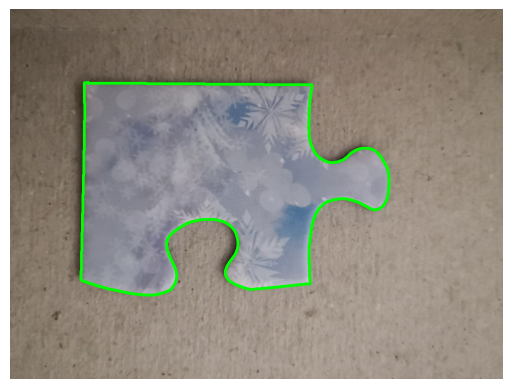

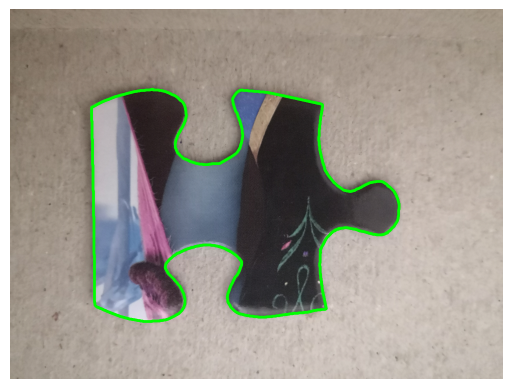

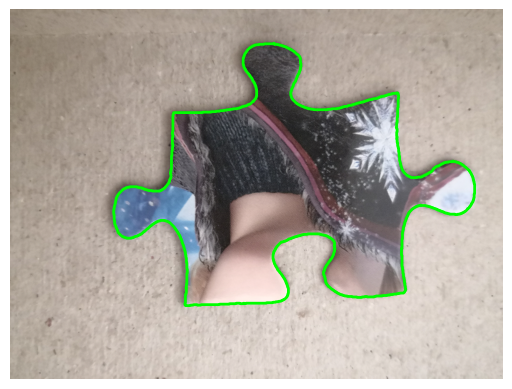

In [81]:
#Show Contours
for i in range(3):
    contours = get_puzzle_contour(msks[i])
    # since we assume the contour closed has the largest area.
    max_contour = max(contours, key=cv2.contourArea)
    contour = get_clockwise_contour(max_contour.reshape(-1, 2))
    # some plots are not closed
    if not np.array_equal(contour[0], contour[-1]):
            # adding the first point to close the contour
            contour = np.vstack([contour, contour[0]])
   
    fig, ax = plt.subplots()

    #  image
    ax.imshow(imgs[i], cmap='gray')

    # contours
    x_coords, y_coords = zip(*contour)
    ax.plot(x_coords, y_coords, c='lime', linewidth=2)
    ax.axis('off')
    plt.show()


## Shape models

In [82]:
with open("./puzzle_corners_1024x768/corners.json", mode="r") as f:
    names, corner_ratios = json.load(f)

#Convert Ratios to coordinates
for picture in range(len(corner_ratios)):
    for points in range(len(corner_ratios[picture])):
        corner_ratios[picture][points]=[corner_ratios[picture][points][0]*1024,corner_ratios[picture][points][1]*768]    

**NOTE:** Using `cv2.CHAIN_APPROX_SIMPLE` is helpful since it only stores the endpoints of the lines that form the contour - this is what we need if we want to find the nearest point in the contour to the corner. makes finding the nearest contour easier.

In [83]:
def extract_sides(contour, corners):
    corner_indices=[]
    for corner in corners:
        #get distance
        corner_dists = np.linalg.norm(contour - corner, axis=-1)
        # using argmin to get the closest points since smaller distance
        nearest_idx = np.argmin(corner_dists)
        corner_indices.append(nearest_idx)

    corner_indices = sorted(corner_indices)
  

    

    side_contours = []
    for i in range(4):
        start_idx = corner_indices[i]
        end_idx = corner_indices[(i + 1) % 4]
        if start_idx < end_idx:
            side_contour = contour[start_idx:end_idx + 1]
        else:
            side_contour = np.concatenate([contour[start_idx:], contour[:end_idx + 1]])
        
        side_contours.append(side_contour)

    return side_contours




In [31]:
### helper to plot the contours
def plot_puzzle_piece(img,contour, corners, sides):
    corners = np.array(corners)
    # colors of quad and sides
    quad_color = (1.0, 1.0, 1.0)  
    side_colors = [(1.0, 0.75, 0.0),
                   
                #    (0.0, 0.25, 1.0), 
                    # (0.0, 1.0, 0.0), 
                    # (1.0, 0.0, 0.0),] 
    ]
    
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    
    # contour for each side with different colors
    for i, side in enumerate(sides):
        # ide contour in its color
        plt.plot(side[:, 0], side[:, 1], color=side_colors[i], linewidth=2)

        # colored dot at the start of each side
        plt.scatter(side[0, 0], side[0, 1], color=side_colors[i], zorder=6, s=100)

        # white dots along the side
        # num_points = 10
        # sparse_indices = np.linspace(0, len(side) - 1, num_points, dtype=int)
        
        
        # plt.scatter(side[sparse_indices, 0], side[sparse_indices, 1], color='white', zorder=5, s=20)

    




    plt.show()

In [32]:
def plot_side(img_index):
    contours = get_puzzle_contour(msks[img_index])
    print("contours\n",contours)
    max_contour = max(contours, key=cv2.contourArea)
    print("Max contour",max_contour)
    contour = get_clockwise_contour(max_contour.reshape(-1, 2))
    print("contours\n",contours)
    # some plots are not closed
    if not np.array_equal(contour[0], contour[-1]):
            # adding the first point to close the contour
        
            contour = np.vstack([contour, contour[0]])
            
    sides = extract_sides(contour,corner_ratios[img_index])
    
    plot_puzzle_piece(imgs[img_index],contour, corner_ratios[img_index], sides)


contours
 [array([[292, 166],
       [291, 167],
       [281, 167],
       ...,
       [309, 167],
       [297, 167],
       [296, 166]], dtype=int32)]
Max contour [[292 166]
 [291 167]
 [281 167]
 ...
 [309 167]
 [297 167]
 [296 166]]
contours
 [array([[292, 166],
       [291, 167],
       [281, 167],
       ...,
       [309, 167],
       [297, 167],
       [296, 166]], dtype=int32)]


IndexError: list index out of range

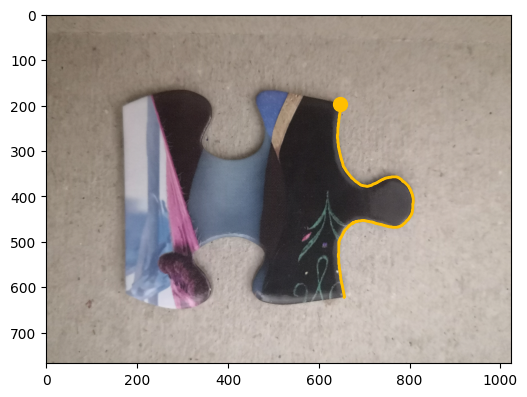

In [34]:
plot_side(1)

[625. 363.]
-1.5610878939607877


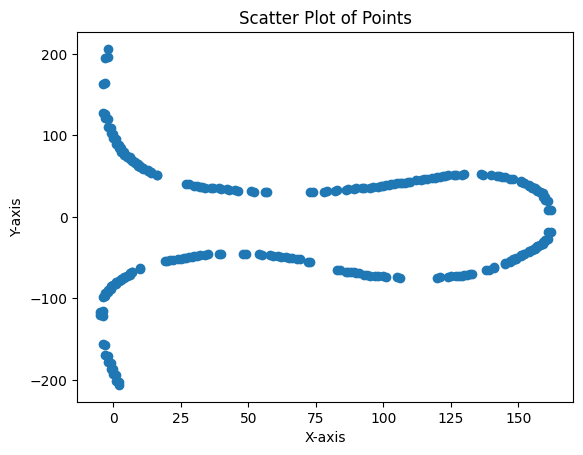

In [37]:
def transform_puzzle_side(contour): # contour is a side
    point1 = np.array(contour[0])
    point2 = np.array(contour[-1])
    line = np.array([point1,point2])

    midpoint = (point1 + point2)/2
    print(midpoint)

    #Do translation
    translated_contour = contour - midpoint

    #Do Rotation
    theta =np.arctan2(translated_contour[0][1],translated_contour[0][0])
    print(theta)


    x_coords = translated_contour[:, 0]
    y_coords = translated_contour[:, 1]

    # Create the scatter plot
    plt.scatter(x_coords, y_coords)

    # Optional: Add titles and labels
    plt.title('Scatter Plot of Points')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    # Show the plot
contours = get_puzzle_contour(msks[0])
# since we assume the contour closed has the largest area.
max_contour = max(contours, key=cv2.contourArea)
contour = get_clockwise_contour(max_contour.reshape(-1, 2))
# some plots are not closed
if not np.array_equal(contour[0], contour[-1]):
        # adding the first point to close the contour
        contour = np.vstack([contour, contour[0]])
        
sides = extract_sides(contour,corner_ratios[0])
transform_puzzle_side(sides[0])
